### Instructor Demo: Financial Forecasting Part III

This program executes `1000` simulations of stock price trajectory for `TSLA` and `SPHD` over the next `252 * 3` trading days (or 3 years of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `75%` of capital allocated to `TSLA` and `25%` of capital allocated to `SPHD`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': '2ad15d25-a851-44c9-891f-d19e54a905d5',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc 8.250% Series A Cumulative Redeemable '
             'Preferred Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-A',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': 'b769adcd-7514-4e56-85ee-dabc29e801e4',
     'marginable': True,
     'name': 'Arbor Realty Trust, Inc. 7.75% Series B Preferred',
     'shortable': False,
     'status': 'active',
     'symbol': 'ABR-B',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'add2d2c9-fce7-4155-a232-5ae7470e7178',
     'marginable': True,
     'name': 'Arch Capital Group Ltd. Depositary Shares Each Representing '
             '1/1,000th Interest in a Share of 5.45% Non

### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [4]:
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

display(asset_info_df.head(10))

,symbol
0,ABILF
1,ABR-A
2,ABR-B
3,ACGLO
4,ACIA
5,KTP
6,ACIO
7,LVHE
8,ACIU
9,ACLS


In [5]:
# Set the list of tickers
tickers = ["SPHD", "TSLA"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = pd.Timestamp.now(tz="America/Chicago")
start_date = (end_date - pd.DateOffset(years=1)).isoformat()

# Get 1 year's worth of historical data for TSLA and SPHD.
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

SPHD                                    TSLA  \
                            open     high     low  close  volume    open   
2019-05-30 00:00:00-04:00  40.50  40.6200  40.230  40.33  387237  188.75   
2019-05-31 00:00:00-04:00  39.88  39.9000  39.880  39.88   39380  185.10   
2019-06-03 00:00:00-04:00  39.97  40.4300  39.963  40.39  666052  185.51   
2019-06-04 00:00:00-04:00  40.69  40.9800  40.540  40.98  470547  181.10   
2019-06-05 00:00:00-04:00  41.14  41.1973  40.840  41.19  465499  198.47   

                                                                  
                               high       low    close    volume  
2019-05-30 00:00:00-04:00  192.2550  187.0200  188.180   7409500  
2019-05-31 00:00:00-04:00  189.9204  184.1000  185.480   9599948  
2019-06-03 00:00:00-04:00  186.6800  176.9919  179.010  12380263  
2019-06-04 00:00:00-04:00  193.9800  179.6100  193.910  13115692  
2019-06-05 00:00:00-04:00  201.2782  191.8486  196.677  12570739

### Drop Extraneous Columns

In [6]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPHD,TSLA
,close,close
2019-05-30 00:00:00-04:00,40.33,188.180
2019-05-31 00:00:00-04:00,39.88,185.480
2019-06-03 00:00:00-04:00,40.39,179.010
2019-06-04 00:00:00-04:00,40.98,193.910
2019-06-05 00:00:00-04:00,41.19,196.677


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of `TSLA` and `SPHD`.
daily_returns = df.pct_change()
daily_returns.head()

,SPHD,TSLA
,close,close
2019-05-30 00:00:00-04:00,NaN,NaN
2019-05-31 00:00:00-04:00,-0.011158,-0.014348
2019-06-03 00:00:00-04:00,0.012788,-0.034882
2019-06-04 00:00:00-04:00,0.014608,0.083236
2019-06-05 00:00:00-04:00,0.005124,0.014270


### Calculate Value of Average Daily Returns

In [9]:
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_sphd = daily_returns.mean()['SPHD']['close']
avg_daily_return_tsla = daily_returns.mean()['TSLA']['close']
print(avg_daily_return_sphd)
print(avg_daily_return_tsla)

-0.0005085525748406039
0.007078925806121939


### Calculate Value of Standard Deviation of Daily Returns

In [10]:
# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_sphd= daily_returns.std()['SPHD']['close']
std_dev_daily_return_tsla = daily_returns.std()['TSLA']['close']
print(std_dev_daily_return_sphd)
print(std_dev_daily_return_tsla)

0.022460883237204358
0.048073275086732065


### Run the Monte Carlo Simulation and Save Results to DataFrame

In [11]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252 * 3

# Set last closing prices of `TSLA` and `SPHD`
sphd_last_price = df['SPHD']['close'][-1]
tsla_last_price = df['TSLA']['close'][-1]


# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_sphd_prices = [sphd_last_price]
    simulated_tsla_prices = [tsla_last_price]    
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_sphd_price = simulated_sphd_prices[-1] * (1 + np.random.normal(avg_daily_return_sphd, std_dev_daily_return_sphd))
        simulated_tsla_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return_tsla, std_dev_daily_return_tsla))
        
        # Append the simulated price to the list
        simulated_sphd_prices.append(simulated_sphd_price)
        simulated_tsla_prices.append(simulated_tsla_price)
        
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["SPHD prices"] = pd.Series(simulated_sphd_prices)
    simulated_price_df["TSLA prices"] = pd.Series(simulated_tsla_prices)    
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (75% TSLA; 25% SPHD)
    weights = [0.75, 0.25]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998697,0.970643,1.010814,1.012913,1.002861,1.004161,0.985805,1.001963,0.998555,1.032100,...,0.975724,1.005519,1.021644,1.017746,0.980362,1.022777,0.978360,0.944925,0.981284,1.003757
2,0.998499,0.971219,1.021105,1.020637,1.019389,0.978424,1.003169,1.003461,1.006521,1.014061,...,0.931621,1.022979,1.051610,0.999562,0.961218,1.019178,0.942036,0.941346,0.993796,1.000484
3,1.013794,0.936191,1.056494,1.028711,1.024002,0.966685,1.013712,1.027608,1.017003,0.990841,...,0.972287,1.059043,1.009698,1.011761,0.937388,1.022051,0.959873,0.942742,0.997939,1.035201
4,0.962751,0.945043,1.080312,1.006067,1.020237,0.950902,0.990959,0.995983,0.987271,0.991575,...,0.973008,1.054579,1.011273,1.018671,0.916748,1.048374,0.942283,0.981137,1.006510,1.047508


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next 3 Years (252 * 3 Trading Days)

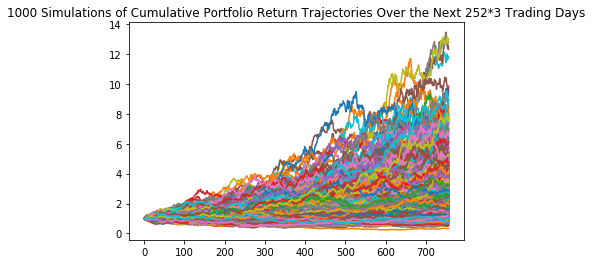

In [12]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252*3 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [13]:
# Select the last row for projecting stock prices (prices of each simulation on the last trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.629742
1    2.156969
2    3.694873
3    4.550059
4    0.909876
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the Last Trading Day

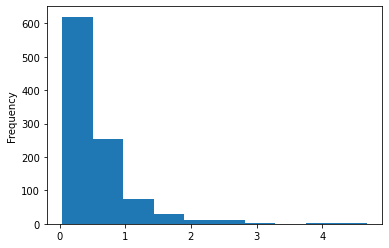

In [14]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices



### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [15]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges



(0.0368, 0.506]    0.620
(0.506, 0.969]     0.253
(0.969, 1.433]     0.073
(1.433, 1.896]     0.030
(2.359, 2.823]     0.010
(1.896, 2.359]     0.010
(4.213, 4.676]     0.002
(3.75, 4.213]      0.001
(2.823, 3.286]     0.001
(3.286, 3.75]      0.000
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [16]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices




0.025    0.099316
0.975    1.864628
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

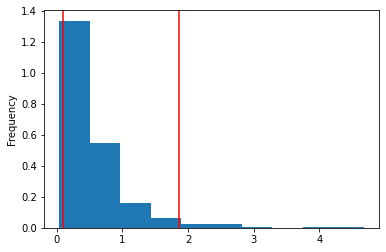

In [17]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval






### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 3 Trading Years

In [18]:
# Set initial investment


# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns

                                                    
# Print the results



There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $993.1620572982353 and $18646.27613631054


### Answer the Following Questions

* What is the expected range of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative investment for the given portfolio?